In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import json
import numpy as np
import sys
sys.path.append('../')
from dataset_creation.generate_data import pad_string
import evaluation_utils.eval_grouping_queries as queries
from evaluation_utils.plotting_utils import *
import evaluation_utils.exploration_utils as data_manip

In [5]:
result_dir = "../data/masked_word_result_data/roberta/"

data_files = ["material_perf_ft_10.csv", "social_perf_ft_10.csv", "physical_perf_ft_10.csv"]

config_dir = "../data/truism_data/"

config_files = ["social_data_2.json", "material_data_2.json", "physical_data_2.json"]

In [6]:
data = []

for file in data_files:
    full_path = result_dir + file
    data.append(pd.read_csv(full_path))

configs = []

for file in config_files:
    full_path = config_dir + file
    with open(full_path) as f:
        configs.append(json.load(f))

In [9]:
len(data[0]["truism_number"])

48

In [11]:
accuracy_sep_dict = {
                      "template" : [],
                      "set_number" : [],
                      "linguistic_operator" : [],
                      "asymetric_operator" : [],
                      "stat" : []
                    }


ratio_sep_dict = {
                    "template" : [],
                    "set_number" : [],
                    "linguistic_operator" : [],
                    "asymetric_operator" : [],
                    "stat" : []
                 }


last_num = 0
for i, d in enumerate(data):
    accuracy_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                          accuracy_sep_dict,
                                                                          stat_name="avg_binary_score",
                                                                          last_num=last_num,
                                                                          option=0, 
                                                                          param_data=configs[i])
    ratio_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                       ratio_sep_dict,
                                                                       stat_name="avg_ratio_score",
                                                                       last_num=last_num,
                                                                       option=0,
                                                                       param_data=configs[i])
    last_num += 20

In [12]:
accuracy_merged_dict = {
                         "template" : [],
                         "set_number" : [],
                         "perturbation" : [],
                         "stat" : []
                       }

ratio_merged_dict = {
                      "template" : [],
                      "set_number" : [],
                      "perturbation" : [],
                      "stat" : []
                    }

last_num = 0
for i, d in enumerate(data):
    accuracy_merged_dict = data_manip.transform_results_to_merged_sql_dict(d, 
                                                                           accuracy_merged_dict,
                                                                           stat_name="avg_binary_score",
                                                                           last_num=last_num,
                                                                           option=0,
                                                                           param_data=configs[i])
    ratio_merged_dict = data_manip.transform_results_to_merged_sql_dict(d, 
                                                                        ratio_merged_dict,
                                                                        stat_name="avg_ratio_score",
                                                                        last_num=last_num,
                                                                        option=0,
                                                                        param_data=configs[i])
    last_num += 20

In [13]:
acc_sep_df = pd.DataFrame.from_dict(accuracy_sep_dict)
ratio_sep_df = pd.DataFrame.from_dict(ratio_sep_dict)

acc_merged_df = pd.DataFrame.from_dict(accuracy_merged_dict)
ratio_merged_df = pd.DataFrame.from_dict(ratio_merged_dict)

In [20]:
acc_sep_df.head()

,template,set_number,linguistic_operator,asymetric_operator,stat
0,4,15,original,original,0.9
1,4,15,original,asymmetric_premise,0.3
2,4,15,original,asymmetric_conclusion,0.0
3,4,15,negation,original,1.0
4,4,15,negation,asymmetric_premise,0.0


In [19]:
acc_merged_df.head()

,template,set_number,perturbation,stat
0,4,15,original-original,0.9
1,4,15,original-asymmetric_premise,0.3
2,4,15,original-asymmetric_conclusion,0.0
3,4,15,negation-original,1.0
4,4,15,negation-asymmetric_premise,0.0


In [21]:
avg_acc_by_template = queries.run_template_grouping_query(acc_merged_df)
avg_ratio_by_template = queries.run_template_grouping_query(ratio_merged_df)

In [22]:
avg_acc_by_template

,template,avg_stat,count
0,1,0.483333,48
1,4,0.501042,96


In [23]:
save_dir = "../data/analyzed_masked_word_data/roberta_ft/"
model = "RoBERTa"

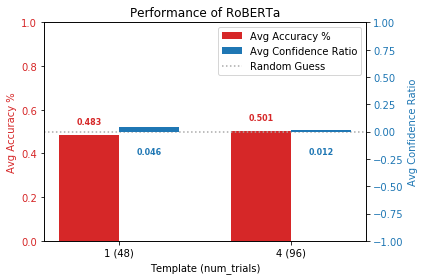

In [29]:
x_labels = ["1 (48)", "4 (96)"]
x_label = "Template (num_trials)"
left_units = "Avg Accuracy %"
right_units = "Avg Confidence Ratio"
left_bar_data = [round(avg_acc_by_template[avg_acc_by_template["template"] == str(i)]["avg_stat"].item(), 3) for i in [1, 4]]
right_bar_data = [round(avg_ratio_by_template[avg_ratio_by_template["template"] == str(i)]["avg_stat"].item(), 3) for i in [1, 4]]
title = "Performance of {}".format(model)
display_two_axis_bar_plot(x_labels, x_label, left_units, right_units, 
                          left_bar_data, right_bar_data, title, x_ticks_rotation=0,
                          save_dir=save_dir)



In [30]:
avg_acc_by_linguistic_op = queries.run_linguistic_operator_grouping_query(acc_sep_df)
avg_ratio_by_linguistic_op = queries.run_linguistic_operator_grouping_query(ratio_sep_df)

In [31]:
avg_acc_by_linguistic_op

,linguistic_operator,avg_stat,count
0,original,0.650000,6
1,negation,0.666667,6
2,antonym,0.533333,6
3,paraphrase,0.766667,6
4,paraphrase_inversion,0.300000,6
5,negation_antonym,0.533333,6
6,negation_paraphrase,0.033333,6
7,negation_paraphrase_inversion,0.666667,6


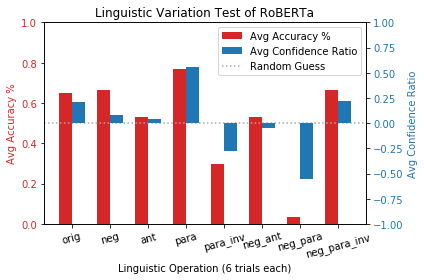

In [33]:
# Before Saving this, you must change what's going on inside autolabel to make sure 
# numbers are aligned to their correct positions
#
# Specifically you need to fiddle with this: x = rect.get_x() + rect.get_width() / 2
# in the bottom case, I use x = rect.get_x() + 8*rect.get_width() / 9

x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operation (6 trials each)"
left_units = "Avg Accuracy %"
right_units = "Avg Confidence Ratio"
left_bar_data = [round(row["avg_stat"], 3) for i, row in avg_acc_by_linguistic_op.iterrows()]
right_bar_data = [round(row["avg_stat"], 3) for i, row in avg_ratio_by_linguistic_op.iterrows()]
title = "Linguistic Variation Test of {}".format(model)
display_two_axis_bar_plot(x_labels, x_label, left_units, right_units, 
                          left_bar_data, right_bar_data, title,
                          save_dir=save_dir, add_nums_to_bars=False
                          )




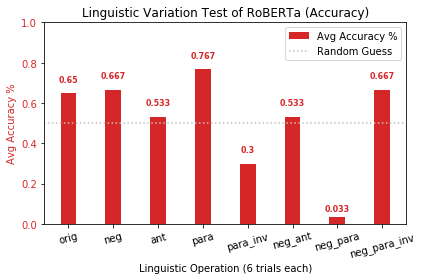

In [34]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operation (6 trials each)"
left_units = "Avg Accuracy %"
left_bar_data = [round(row["avg_stat"], 3) for i, row in avg_acc_by_linguistic_op.iterrows()]
title = "Linguistic Variation Test of {} (Accuracy)".format(model)
display_bar_plot(x_labels, x_label, left_units, left_bar_data, title, color="tab:red",
                 save_dir=save_dir)

In [37]:
avg_acc_by_logical_op = queries.run_asymetric_operator_grouping_query(acc_sep_df)
avg_ratio_by_logical_op = queries.run_asymetric_operator_grouping_query(ratio_sep_df)

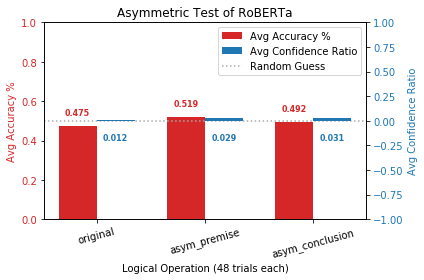

In [38]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operation (48 trials each)"
left_units = "Avg Accuracy %"
right_units = "Avg Confidence Ratio"
left_bar_data = [round(row["avg_stat"], 3) for i, row in avg_acc_by_logical_op.iterrows()]
right_bar_data = [round(row["avg_stat"], 3) for i, row in avg_ratio_by_logical_op.iterrows()]
title = "Asymmetric Test of {}".format(model)
display_two_axis_bar_plot(x_labels, x_label, left_units, right_units, 
                          left_bar_data, right_bar_data, title,
                          save_dir=save_dir)

In [50]:
material_more_less = data_manip.filter_data_into_more_less_by_orig_comparison(data[0],
                                                                            configs[0])
social_more_less = data_manip.filter_data_into_more_less_by_orig_comparison(data[1],
                                                                            configs[1])
physical_more_less = data_manip.filter_data_into_more_less_by_orig_comparison(data[2],
                                                                            configs[2])


In [51]:
more = [material_more_less[0], social_more_less[0], physical_more_less[0]]
less = [material_more_less[1], social_more_less[1], physical_more_less[1]]

In [52]:
more_accuracy_sep_dict = {
                           "set_number" : [],
                           "linguistic_operator" : [],
                           "asymetric_operator" : [],
                           "stat" : []
                         }


more_ratio_sep_dict = {
                         "set_number" : [],
                         "linguistic_operator" : [],
                         "asymetric_operator" : [],
                         "stat" : []
                      }


last_num = 0
for i, d in enumerate(more):
    more_accuracy_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                               more_accuracy_sep_dict,
                                                                               stat_name="avg_binary_score",
                                                                               last_num=last_num,
                                                                               option=0)
    more_ratio_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                            more_ratio_sep_dict,
                                                                            stat_name="avg_ratio_score",
                                                                            last_num=last_num,
                                                                            option=0)
    last_num += 10

In [53]:
less_accuracy_sep_dict = {
                           "set_number" : [],
                           "linguistic_operator" : [],
                           "asymetric_operator" : [],
                           "stat" : []
                         }


less_ratio_sep_dict = {
                         "set_number" : [],
                         "linguistic_operator" : [],
                         "asymetric_operator" : [],
                         "stat" : []
                      }


last_num = 0
for i, d in enumerate(less):
    less_accuracy_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                               less_accuracy_sep_dict,
                                                                               stat_name="avg_binary_score",
                                                                               last_num=last_num,
                                                                               option=0)
    less_ratio_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                            less_ratio_sep_dict,
                                                                            stat_name="avg_ratio_score",
                                                                            last_num=last_num,
                                                                            option=0)
    last_num += 10

In [54]:
more_acc_sep_df = pd.DataFrame.from_dict(more_accuracy_sep_dict)
more_ratio_sep_df = pd.DataFrame.from_dict(more_ratio_sep_dict)

less_acc_sep_df = pd.DataFrame.from_dict(less_accuracy_sep_dict)
less_ratio_sep_df = pd.DataFrame.from_dict(less_ratio_sep_dict)

In [55]:
more_avg_acc_by_linguistic_op = queries.run_linguistic_operator_grouping_query(more_acc_sep_df)
less_avg_acc_by_linguistic_op = queries.run_linguistic_operator_grouping_query(less_acc_sep_df)


In [57]:
more_avg_acc_by_linguistic_op

,linguistic_operator,avg_stat,count
0,original,0.725,4
1,negation,0.700,4
2,antonym,0.375,4
3,paraphrase,0.900,4
4,paraphrase_inversion,0.000,4
5,negation_antonym,0.475,4
6,negation_paraphrase,0.000,4
7,negation_paraphrase_inversion,1.000,4


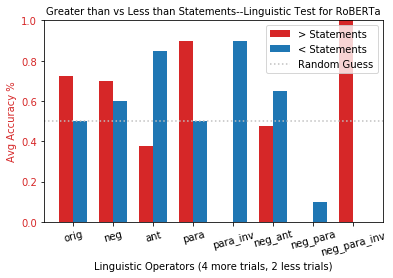

In [59]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (4 more trials, 2 less trials)"
y_label = "Avg Accuracy %"
y_one_label = "> Statements"
data_one = [round(row["avg_stat"], 3) for i, row in more_avg_acc_by_linguistic_op.iterrows()]
y_two_label = "< Statements"
data_two = [round(row["avg_stat"], 3) for i, row in less_avg_acc_by_linguistic_op.iterrows()]
title = "Greater than vs Less than Statements--Linguistic Test for {}".format(model)
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir=save_dir,
                     add_nums_to_bars=False)

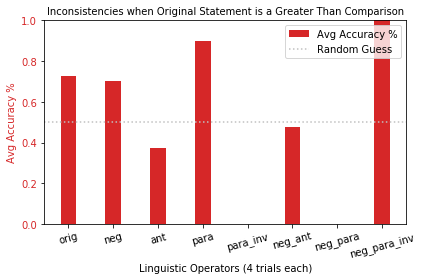

In [62]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (4 trials each)"
y_label = "Avg Accuracy %"
title = "Inconsistencies when Original Statement is a Greater Than Comparison"
more_data = [round(row["avg_stat"], 3) for i, row in more_avg_acc_by_linguistic_op.iterrows()]
display_bar_plot(x_labels, x_label, y_label, more_data, title, color="tab:red",
                 save_dir=save_dir,
                 add_nums_to_bars=False, small_title=True)

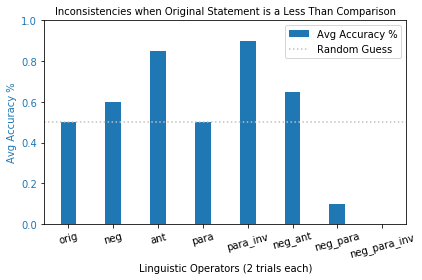

In [63]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (2 trials each)"
y_label = "Avg Accuracy %"
title = "Inconsistencies when Original Statement is a Less Than Comparison"
less_data = [round(row["avg_stat"], 3) for i, row in less_avg_acc_by_linguistic_op.iterrows()]
display_bar_plot(x_labels, x_label, y_label, less_data, title, color="tab:blue",
                 save_dir=save_dir,
                 add_nums_to_bars=False, small_title=True)

In [64]:
more_avg_acc_by_logical_op = queries.run_asymetric_operator_grouping_query(more_acc_sep_df)
less_avg_acc_by_logical_op = queries.run_asymetric_operator_grouping_query(less_acc_sep_df)


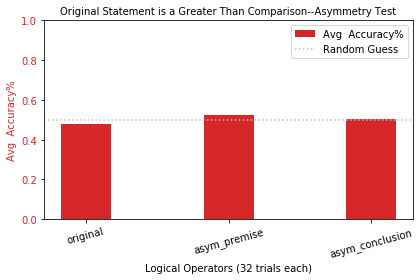

In [65]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operators (32 trials each)"
y_label = "Avg  Accuracy%"
title = "Original Statement is a Greater Than Comparison--Asymmetry Test"
more_data = [round(row["avg_stat"], 3) for i, row in more_avg_acc_by_logical_op.iterrows()]
display_bar_plot(x_labels, x_label, y_label, more_data, title, color="tab:red",
                 save_dir=save_dir,
                 add_nums_to_bars=False, small_title=True)

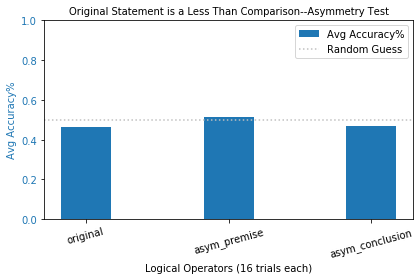

In [66]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operators (16 trials each)"
y_label = "Avg Accuracy%"
title = "Original Statement is a Less Than Comparison--Asymmetry Test"
less_data = [round(row["avg_stat"], 3) for i, row in less_avg_acc_by_logical_op.iterrows()]
display_bar_plot(x_labels, x_label, y_label, less_data, title, color="tab:blue",
                 save_dir=save_dir,
                 add_nums_to_bars=False, small_title=True)

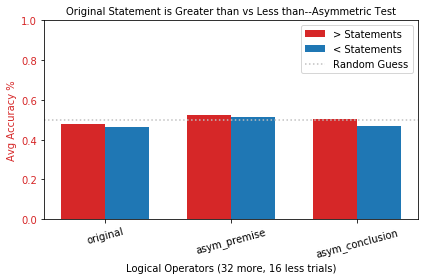

In [67]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operators (32 more, 16 less trials)"
y_label = "Avg Accuracy %"
y_one_label = "> Statements"
data_one = [round(row["avg_stat"], 3) for i, row in more_avg_acc_by_logical_op.iterrows()]
y_two_label = "< Statements"
data_two = [round(row["avg_stat"], 3) for i, row in less_avg_acc_by_logical_op.iterrows()]
title = "Original Statement is Greater than vs Less than--Asymmetric Test"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir=save_dir,
                     add_nums_to_bars=False, small_title=True)

In [68]:
set_acc_df = queries.run_set_grouping_query(acc_sep_df)
set_ratio_df = queries.run_set_grouping_query(ratio_sep_df)

In [70]:
set_acc_df

,set_number,avg_stat,count
0,15,0.512500,24
1,18,0.454167,24
2,35,0.487500,24
3,38,0.479167,24
4,55,0.483333,24
5,58,0.554167,24


In [55]:
# truisms_data

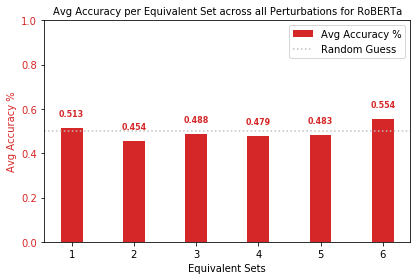

In [80]:
x_label = "Equivalent Sets"
left_units = "Avg Accuracy %"
left_bar_data = [round(row["avg_stat"], 3) for i, row in set_acc_df.iterrows()]
# len(left_bar_data), len(x_labels)
title = "Avg Accuracy per Equivalent Set across all Perturbations for {}".format(model)
display_bar_plot([i for i in range(1, 7)], x_label, left_units, left_bar_data, title, color="tab:red",
                 save_dir=save_dir,
                 add_nums_to_bars=True, label_x_ticks=True, small_title=True,
                 x_ticks_rotation=0)

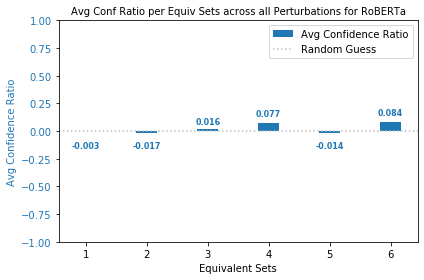

In [92]:
x_label = "Equivalent Sets"
left_units = "Avg Confidence Ratio"
left_bar_data = [round(row["avg_stat"], 3) for i, row in set_ratio_df.iterrows()]
# left_bar_data
title = "Avg Conf Ratio per Equiv Sets across all Perturbations for {}".format(model)
display_bar_plot([i for i in range(1,7)], x_label, left_units, left_bar_data, title, color="tab:blue",
                 save_dir=save_dir,
                 add_nums_to_bars=True, label_x_ticks=True, y_range=[-1,1], small_title=True,
                 x_ticks_rotation=0)